In [112]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

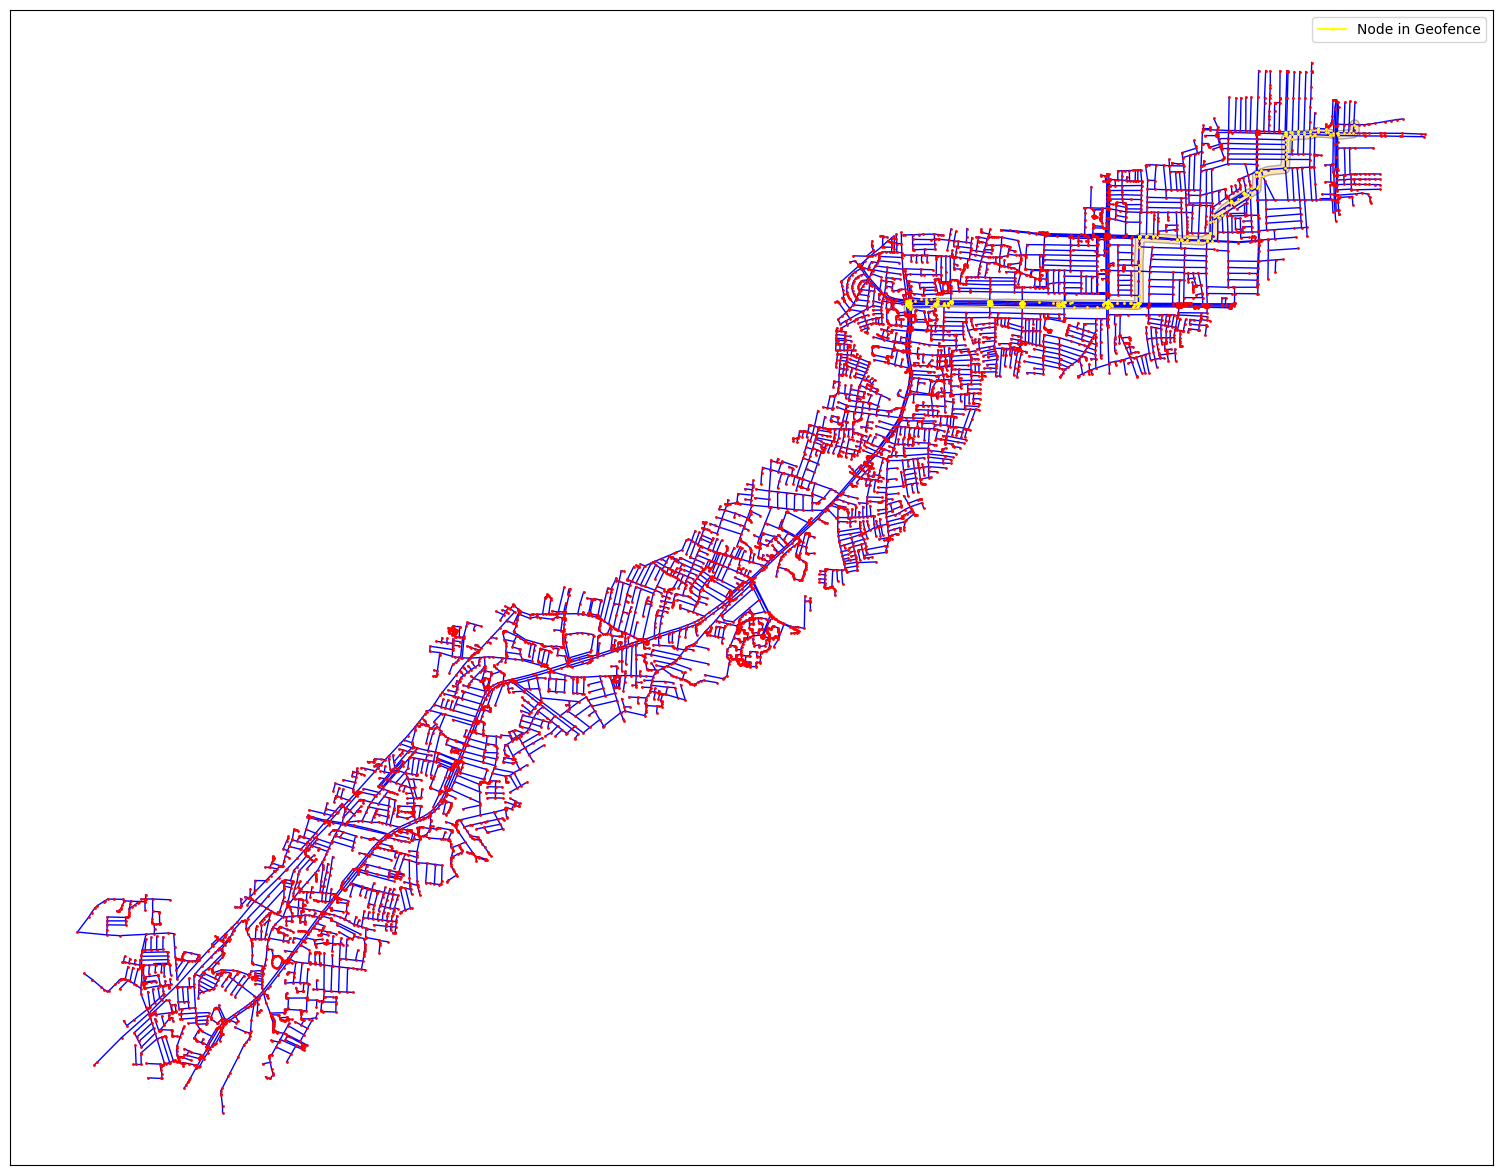

272
[(77.5986683, 12.916703), (77.5877122, 12.9104831), (77.5881489, 12.9104739), (77.5885908, 12.9104575), (77.5888436, 12.9104452), (77.5900908, 12.9103341), (77.5903134, 12.9103197), (77.5904033, 12.9103171), (77.5906916, 12.9103053), (77.5913917, 12.9102883), (77.5919335, 12.9102609), (77.5922365, 12.9102478), (77.5950566, 12.9134483), (77.5950261, 12.9141803), (77.5950195, 12.9144404), (77.5968441, 12.9155036), (77.5968379, 12.9146626), (77.5934053, 12.912616), (77.5934616, 12.9125265), (77.5946384, 12.9132143), (77.5943716, 12.9130649), (77.5938573, 12.912777), (77.592302, 12.9117968), (77.582735, 12.9064176), (77.5830307, 12.9064647), (77.5833933, 12.906459), (77.5854734, 12.9064405), (77.5856795, 12.9064398), (77.5876879, 12.909874), (77.5919312, 12.9102186), (77.5876737, 12.908392), (77.5876664, 12.9087437), (77.5979973, 12.9168625), (77.5983439, 12.916852), (77.5983469, 12.9169197), (77.6011105, 12.9173141), (77.6004706, 12.9168125), (77.6007844, 12.9168034), (77.6010727, 12.

In [113]:
fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for i, node in enumerate(G.nodes()):
    G.nodes[node]['shapefile_index'] = i

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 119
end_index_2 = 181
observations_2 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_2 <= i < end_index_2:
                observations_2.append((point.longitude, point.latitude))

observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    states_in_geofence_2 = []
    for node, position in pos_2.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_2.append(position)

    fig, ax = plt.subplots(figsize=(30, 15))

    for edge in subgraph_2.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_2, pos_2, ax=ax, node_size=1, node_color='red')

    for point in observations_2_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='purple', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_2:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_2))
    print(states_in_geofence_2)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
total_geodesic_distance_km_2 = calculate_geodesic_distance(gpx_coordinates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_2:.2f} km")

print(len(observations_2_no_duplicates))
print(observations_2_no_duplicates)

In [114]:
observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_2_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.5732437, 12.9061862), (77.5733416, 12.9064214), (77.5748932, 12.9063671), (77.5750768, 12.9065665), (77.5753764, 12.9069984), (77.5760157, 12.906575), (77.5771517, 12.9071487), (77.5774854, 12.905132), (77.5774854, 12.905132), (77.5774854, 12.905132), (77.5782584, 12.9065044), (77.5784876, 12.9064115), (77.5793379, 12.9055335), (77.5799092, 12.9071096), (77.5802293, 12.906448), (77.5802293, 12.906448), (77.5805102, 12.9063624), (77.5819845, 12.905777), (77.583058, 12.9064968), (77.5840694, 12.9070513), (77.5860071, 12.9062392), (77.5875032, 12.9064189), (77.5876601, 12.906363), (77.5876737, 12.908392), (77.5876664, 12.9087437), (77.5876664, 12.9087437), (77.5876879, 12.909874), (77.5876879, 12.9104333), (77.5877254, 12.9105298), (77.5885686, 12.9105022), (77.5899205, 12.9109119), (77.5904033, 12.9103171), (77.5906916, 12.9103053), (77.5913957, 12.9102452), (77.5922365, 12.9102478), (77.592291, 12.9114551), (77.5928834, 12.9118042), (77.5934053, 12.91

In [115]:
def swap_coordinates(array):
    return [(lat, lon) for lon, lat in array]
observations_2_swapped = swap_coordinates(observations_2_no_duplicates)
states_in_geofence_2_swapped = swap_coordinates(states_in_geofence_2)
closest_nodes_to_observations_swapped = swap_coordinates(closest_nodes_to_observations)
print("observations_1_swapped:", observations_2_swapped) 
print("states_in_geofence_1_swapped:", states_in_geofence_2_swapped)
print("closest_nodes_to_observations swapped:", closest_nodes_to_observations_swapped)

observations_1_swapped: [(12.9061655, 77.5732539), (12.9064079, 77.5732982), (12.9064589, 77.574845), (12.906508, 77.5751004), (12.906504, 77.5753445), (12.9065071, 77.5760242), (12.9065062, 77.5770948), (12.906499, 77.5776073), (12.9065007, 77.5776153), (12.9065004, 77.5776153), (12.9064624, 77.5782365), (12.9064372, 77.5785095), (12.9064534, 77.5794226), (12.9064392, 77.5799341), (12.9064108, 77.5801196), (12.9064398, 77.5802234), (12.9064206, 77.5806249), (12.9063885, 77.582033), (12.9063921, 77.5830596), (12.9064022, 77.5839501), (12.9063965, 77.5861169), (12.9063494, 77.5875048), (12.9063803, 77.5876589), (12.9077706, 77.587653), (12.9088685, 77.587638), (12.9090138, 77.5876401), (12.9101172, 77.5877065), (12.9103748, 77.5876923), (12.9104532, 77.5877403), (12.9104383, 77.5884615), (12.9103657, 77.5896787), (12.9103068, 77.5904176), (12.9103168, 77.590782), (12.9102602, 77.5916188), (12.9105374, 77.5922988), (12.911439, 77.5923097), (12.9122174, 77.5929957), (12.9124391, 77.593324

In [116]:
score = None
pred = None
shapefile_indices = None
IT = None

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for idx, line in enumerate(data.geometry):
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = geodesic(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]), shapefile_index=idx)
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]), shapefile_index=idx)
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_2):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = geodesic(observations[k], observations[k + 1]).meters
        route_distance = state_distances_2[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(f"Beta value: {beta}")
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    print(sigz)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    return EMIS

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    global score, pred, IT
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1])
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_2 = np.array(observations_2_no_duplicates)
s = np.array(states_in_geofence_2)
s_2 = np.array(closest_nodes_to_observations)
zVec_2 = [geodesic(obs_2[i], obs_2[i + 1]).meters for i in range(len(obs_2) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_2 = calculate_graph_distances(G, s_2)
PRIOR_2 = np.ones(len(states_in_geofence_2)) / len(states_in_geofence_2)
matched_states_2 = viterbi_algorithm(states_in_geofence_2, obs_2, zVec_2, PRIOR_2, state_distances)
gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
total_geodesic_distance_km_2 = calculate_geodesic_distance(gpx_coordinates)
print(matched_states_2)
matched_coords = [states_in_geofence_2[i] for i in matched_states_2]
matched_shapefile_indices = [G.nodes[tuple(coord)]['shapefile_index'] for coord in matched_coords]
print("Matched shapefile indices:", matched_shapefile_indices)

Beta value: 71.11247675993988
8.622347818572779
[155 119 222 224 226 173 231  78  78  78  78 170 169  82 169 169 182 183
  98 236  96 138  88  30  31  31  28  49  48 200   5   7   8 131  11  43
  46  17  21  12  13  13  40  16  16  15  61  61  61  61  61  61  57  34
 268 267  75  68  38  35  35]
Matched shapefile indices: [7273, 8305, 9151, 9155, 9159, 9797, 9163, 828, 828, 828, 828, 8293, 8732, 8731, 8732, 8732, 8733, 8315, 1605, 9171, 888, 4663, 4148, 8100, 882, 882, 883, 4161, 8857, 8862, 3403, 528, 1406, 4158, 423, 434, 459, 8061, 102, 99, 76, 76, 417, 2835, 2835, 662, 4184, 4184, 4184, 4184, 4184, 4184, 8210, 274, 10011, 10008, 722, 687, 690, 299, 299]


In [117]:
matched_coordinates_2 = [states_in_geofence_2[state_idx] for state_idx in matched_states_2]
unique_matched_coordinates_2 = [
    coord for i, coord in enumerate(matched_coordinates_2)
    if i == 0 or coord != matched_coordinates_2[i - 1]
]
print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_2)}")
for coord in unique_matched_coordinates_2:
    lat, lon = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_2:
    lat, lon = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

Number of unique matched coordinates: 48
Latitude: 77.5732437, Longitude: 12.9061862
Latitude: 77.5733416, Longitude: 12.9064214
Latitude: 77.5748932, Longitude: 12.9063671
Latitude: 77.5750864, Longitude: 12.9063613
Latitude: 77.5754652, Longitude: 12.9063536
Latitude: 77.5759867, Longitude: 12.9064275
Latitude: 77.5760157, Longitude: 12.906575
Latitude: 77.5782584, Longitude: 12.9065044
Latitude: 77.5784876, Longitude: 12.9064115
Latitude: 77.5802297, Longitude: 12.9063679
Latitude: 77.5802293, Longitude: 12.906448
Latitude: 77.5802297, Longitude: 12.9063679
Latitude: 77.5805083, Longitude: 12.9064429
Latitude: 77.5823011, Longitude: 12.9064271
Latitude: 77.5830065, Longitude: 12.906267
Latitude: 77.5836074, Longitude: 12.9062293
Latitude: 77.5860071, Longitude: 12.9062392
Latitude: 77.5875032, Longitude: 12.9064189
Latitude: 77.5876601, Longitude: 12.906363
Latitude: 77.5876737, Longitude: 12.908392
Latitude: 77.5876664, Longitude: 12.9087437
Latitude: 77.5876879, Longitude: 12.9098


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 7273 to 8305: 24.39 meters
Segment from state 8305 to 9151: 174.87 meters
Segment from state 9151 to 9155: 21.57 meters
Segment from state 9155 to 9159: 42.29 meters
Segment from state 9159 to 9797: 59.88 meters
Segment from state 9797 to 9163: 16.70 meters
Segment from state 9163 to 828: 255.24 meters
Segment from state 828 to 828: 0.00 meters
Segment from state 828 to 828: 0.00 meters
Segment from state 828 to 828: 0.00 meters
Segment from state 828 to 8293: 27.58 meters
Segment from state 8293 to 8732: 194.49 meters
Segment from state 8732 to 8731: 40.74 meters
Segment from state 8731 to 8732: 40.74 meters
Segment from state 8732 to 8732: 0.00 meters
Segment from state 8732 to 8733: 32.90 meters
Segment from state 8733 to 8315: 200.15 meters
Segment from state 8315 to 1605: 504.41 meters
Segment from state 1605 to 9171: 67.71 meters
Segment from state 9171 to 888: 402.70 meters
Segm

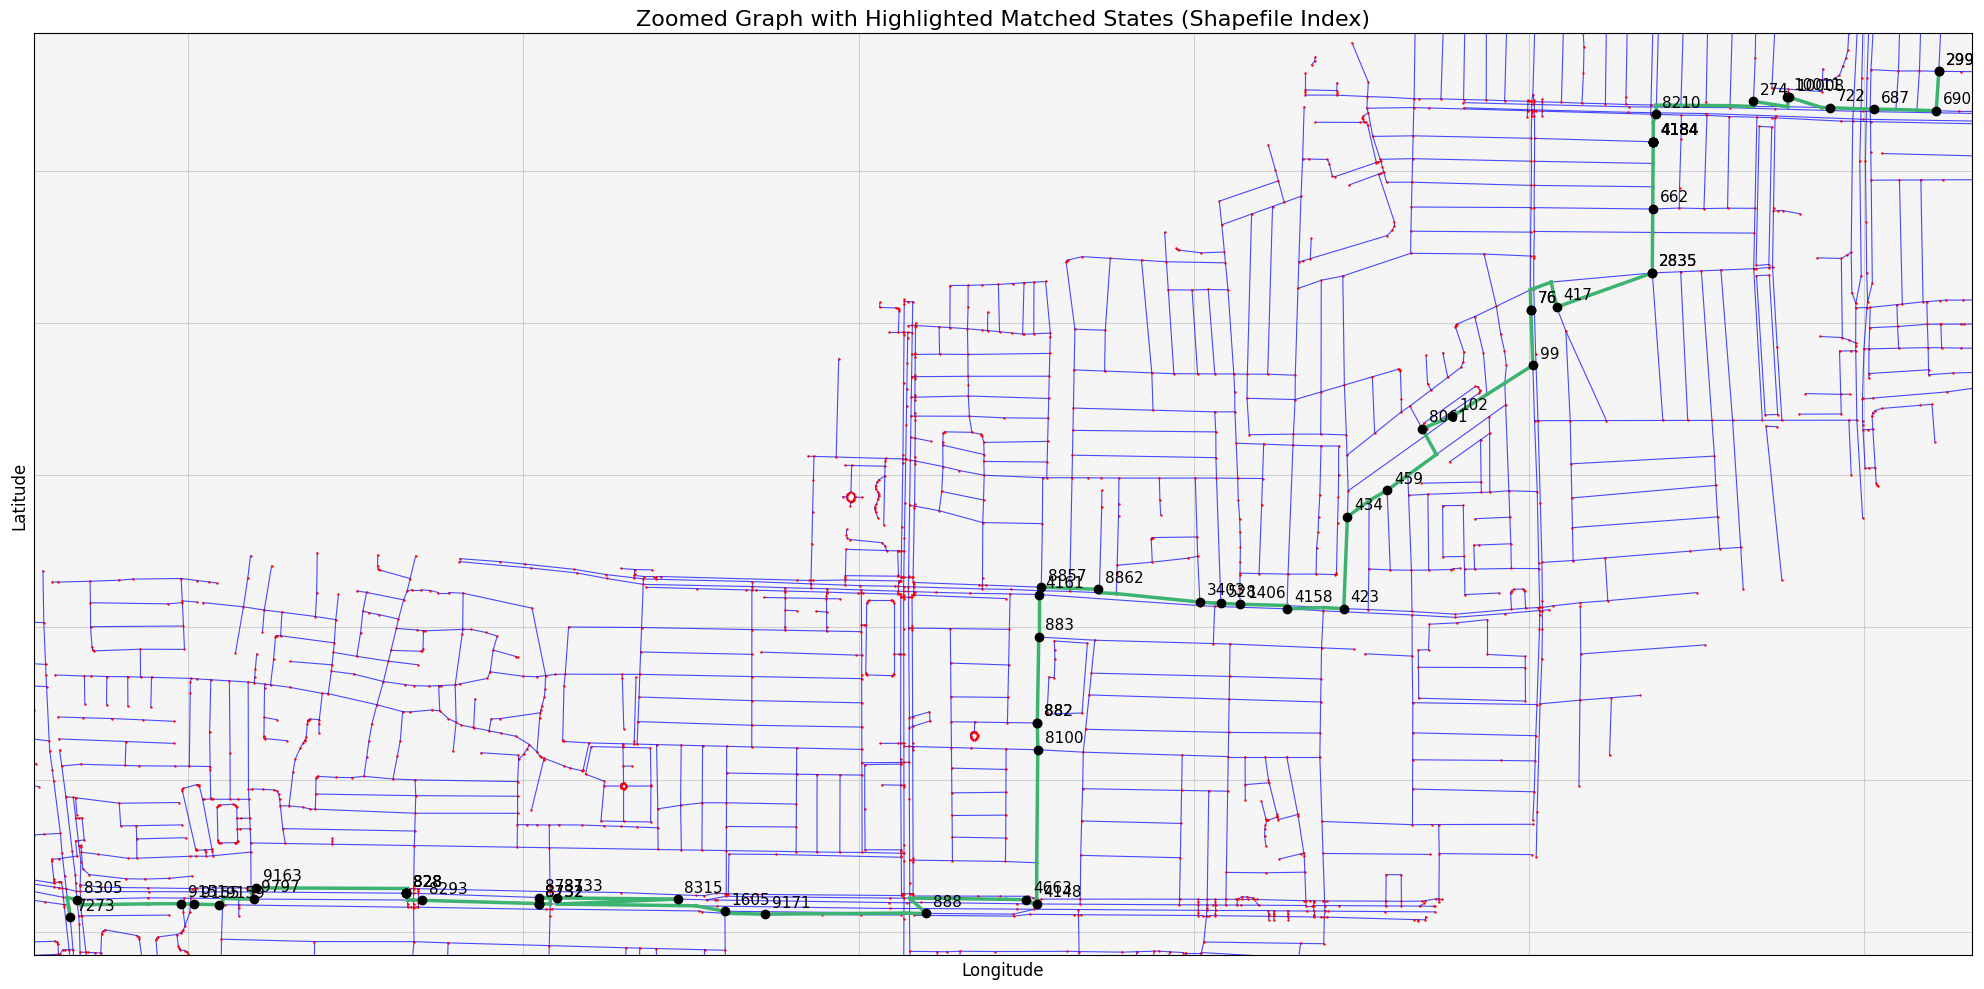

In [118]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos]
valid_highlighted_nodes_2 = [node for node in valid_highlighted_nodes_2 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_2) > 2:
    path_nodes_2 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_2)
else:
    path_nodes_2 = valid_highlighted_nodes_2

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_2)

fig, ax = plt.subplots(figsize=(20, 10))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_2:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_2) - 1):
    start = path_nodes_2[i]
    end = path_nodes_2[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)
x_coords = [coord[0] for coord in path_nodes_2]
y_coords = [coord[1] for coord in path_nodes_2]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+-------------+-----------------+
|   Path Length |    Geodesic |   distance_diff |
+===============+=============+=================+
|      45.2399  |  27.2442    |      17.9957    |
+---------------+-------------+-----------------+
|     176.345   | 167.962     |       8.3835    |
+---------------+-------------+-----------------+
|      20.9803  |  28.2446    |       7.26425   |
+---------------+-------------+-----------------+
|      41.1182  |  26.4947    |      14.6235    |
+---------------+-------------+-----------------+
|      65.402   |  73.7654    |       8.36342   |
+---------------+-------------+-----------------+
|      25.5686  | 116.187     |      90.6186    |
+---------------+-------------+-----------------+
|     253.551   |  55.6249    |     197.926     |
+---------------+-------------+-----------------+
|       0       |   0.888338  |       0.888338  |
+---------------+-------------+-----------------+
|       0       |   0.0331889 |       0.0331889 |


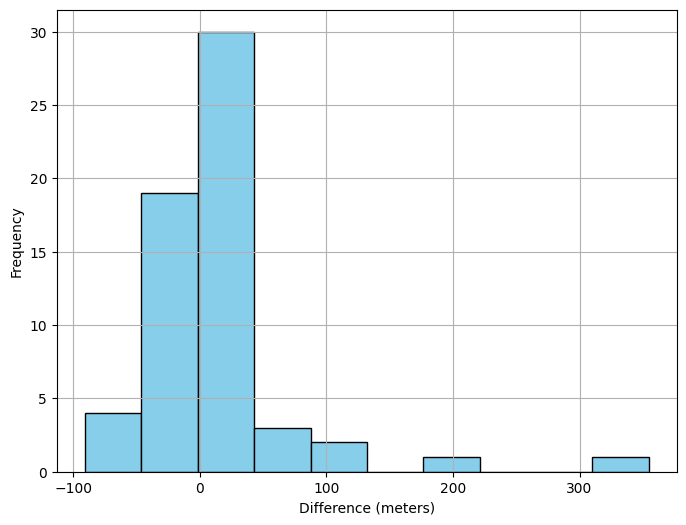

In [119]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_2_2 = []
distances_2 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

gpx_coordinates_path = [(lat, lon) for lon, lat in path_nodes_2]
consecutive_distances_km_2, total_distance = calculate_consecutive_geodesic_distances(gpx_coordinates_path, distances_2)

valid_highlighted_indices = [path_nodes_2.index(node) for node in valid_highlighted_nodes_2 if node in path_nodes_2]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_2[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

gpx_coordinates_obs = [(lat, lon) for lon, lat in observations_2_no_duplicates]
consecutive_distances_km_2, _ = calculate_consecutive_geodesic_distances(gpx_coordinates_obs, distances_2_2)

data = []
for i in range(max(len(highlighted_distances), len(distances_2_2))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_2_2[i] if i < len(distances_2_2) else "", 
        abs(highlighted_distances[i] - distances_2_2[i]) if i < len(highlighted_distances) and i < len(distances_2_2) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_2_2):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_2_2), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_2_2 arrays have different lengths. Cannot compute differences.")


In [120]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_2_2))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_2_2[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)


+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|       6 |           253.551 |        55.6249 |             197.926 |
+---------+-------------------+----------------+---------------------+
|      17 |           466.087 |       111.413  |             354.674 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[6, 17]


Total distance of the shortest path: 4152.94 meters
Total geodesic distance : 4046.88 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5732539, 12.9061655)  (77.5732437, 12.9061862)               7273
          1  (77.5732982, 12.9064079)  (77.5733416, 12.9064214)               8305
          2  (77.574845, 12.9064589)   (77.5748932, 12.9063671)               9151
          3  (77.5751004, 12.906508)   (77.5750864, 12.9063613)               9155
          4  (77.5753445, 12.906504)   (77.5754652, 12.9063536)               9159
          5  (77.5760242, 12.9065071)  (77.5759867, 12.9064275)               9797
          6  (77.5770948, 12.9065062)  (77.5760157, 12.906575)                9163
          7  (77.5776073, 12.906499)   (77.5782584, 12.9065044)                828
          8  (77.5776

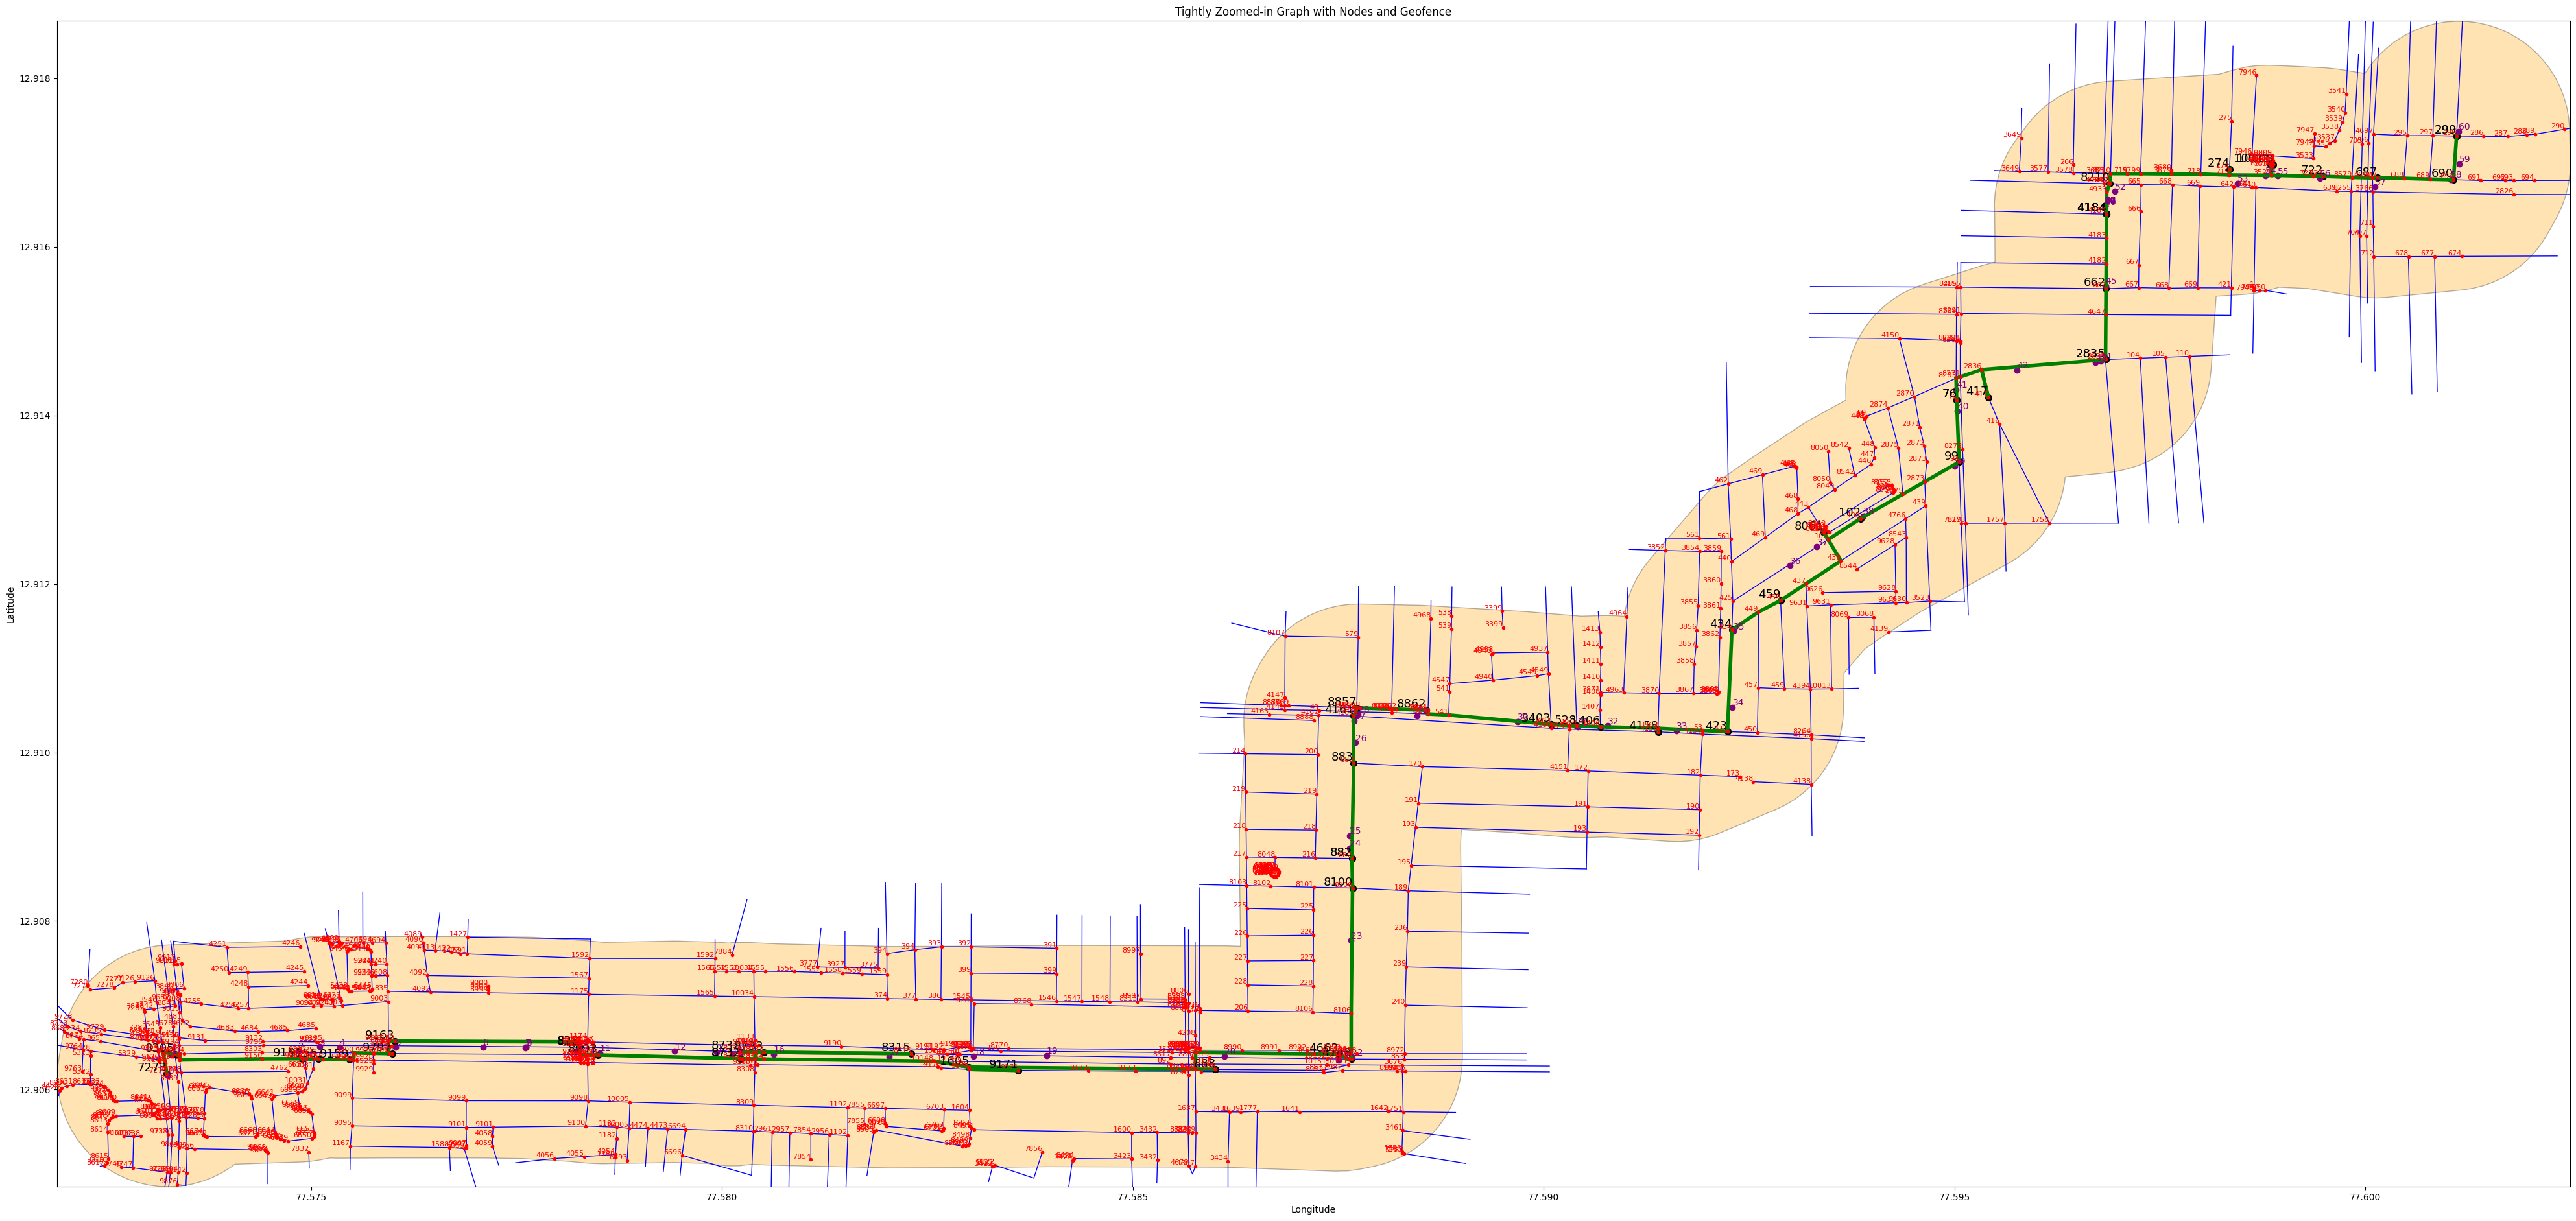

In [121]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate


fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2_2 = 119
end_index_2_2 = 181

observations_2 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_2_2 <= i < end_index_2_2
]

observations_2_no_duplicates = [pt for i, pt in enumerate(observations_2) if i == 0 or pt != observations_2[i - 1]]

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    nodes_in_geofence = [node for node, position in pos_2.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_2.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_2[u], pos_2[v]))

    fig, ax = plt.subplots(figsize=(50, 60))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos_2]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_2 if Point(pos_2[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    # Plot geofence
    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    # Segment-wise path plotting and distance
    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_2, start, end):
            path = shortest_path_geodesic_weight(subgraph_2, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_2[node_start], pos_2[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_2[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    # Total distances
    gpx_coordinates = [(lat, lon) for lon, lat in observations_2_no_duplicates]
    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(gpx_coordinates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    # Node indexing in geofence
    for node in nodes_in_geofence:
        x, y = pos_2[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    # --- Added Table Printing Section ---
    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    # Final plot limits and display
    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [122]:
index1 = 8303
index2 = 9163
index_to_coord = {v: k for k, v in coord_to_index.items()}
node1 = index_to_coord.get(index1)
node2 = index_to_coord.get(index2)

if node1 is None or node2 is None:
    print("Invalid index.")
elif nx.has_path(subgraph, node1, node2):
    print("Path exists between the nodes.")
    path = nx.shortest_path(
        subgraph,
        source=node1,
        target=node2,
        weight=lambda u, v, d: geodesic_distance(pos[u], pos[v])
    )

    total_length = 0
    for u, v in zip(path[:-1], path[1:]):
        total_length += geodesic_distance(pos[u], pos[v])

    heading_angle = calculate_heading(node1, node2)
    
    print("Shortest path length (meters):", total_length)
    print("Number of edges in path:", len(path) - 1)
    print(f"Heading angle from node {index1} to {index2}: {heading_angle:.2f}°")


Path exists between the nodes.
Shortest path length (meters): 0.18423280950040788
Number of edges in path: 8
Heading angle from node 8303 to 9163: 1.00°


Candidate idx: 9797, Angle Difference: 0.01°, Distance Difference: 0.1195 km
Candidate idx: 9167, Angle Difference: 0.06°, Distance Difference: 0.1360 km
Candidate idx: 8295, Angle Difference: 0.06°, Distance Difference: 0.1457 km
Candidate idx: 9200, Angle Difference: 0.06°, Distance Difference: 0.1540 km
Candidate idx: 8293, Angle Difference: 0.07°, Distance Difference: 0.1597 km
Candidate idx: 9201, Angle Difference: 0.27°, Distance Difference: 0.1550 km
Candidate idx: 4911, Angle Difference: 0.31°, Distance Difference: 0.1469 km
Candidate idx: 9168, Angle Difference: 0.31°, Distance Difference: 0.1371 km
Candidate idx: 9199, Angle Difference: 0.38°, Distance Difference: 0.1561 km
Candidate idx: 4912, Angle Difference: 0.40°, Distance Difference: 0.1479 km
Candidate idx: 9166, Angle Difference: 0.42°, Distance Difference: 0.1381 km
Candidate idx: 828, Angle Difference: 0.43°, Distance Difference: 0.1368 km
Candidate idx: 9201, Angle Difference: 0.53°, Distance Difference: 0.1561 km


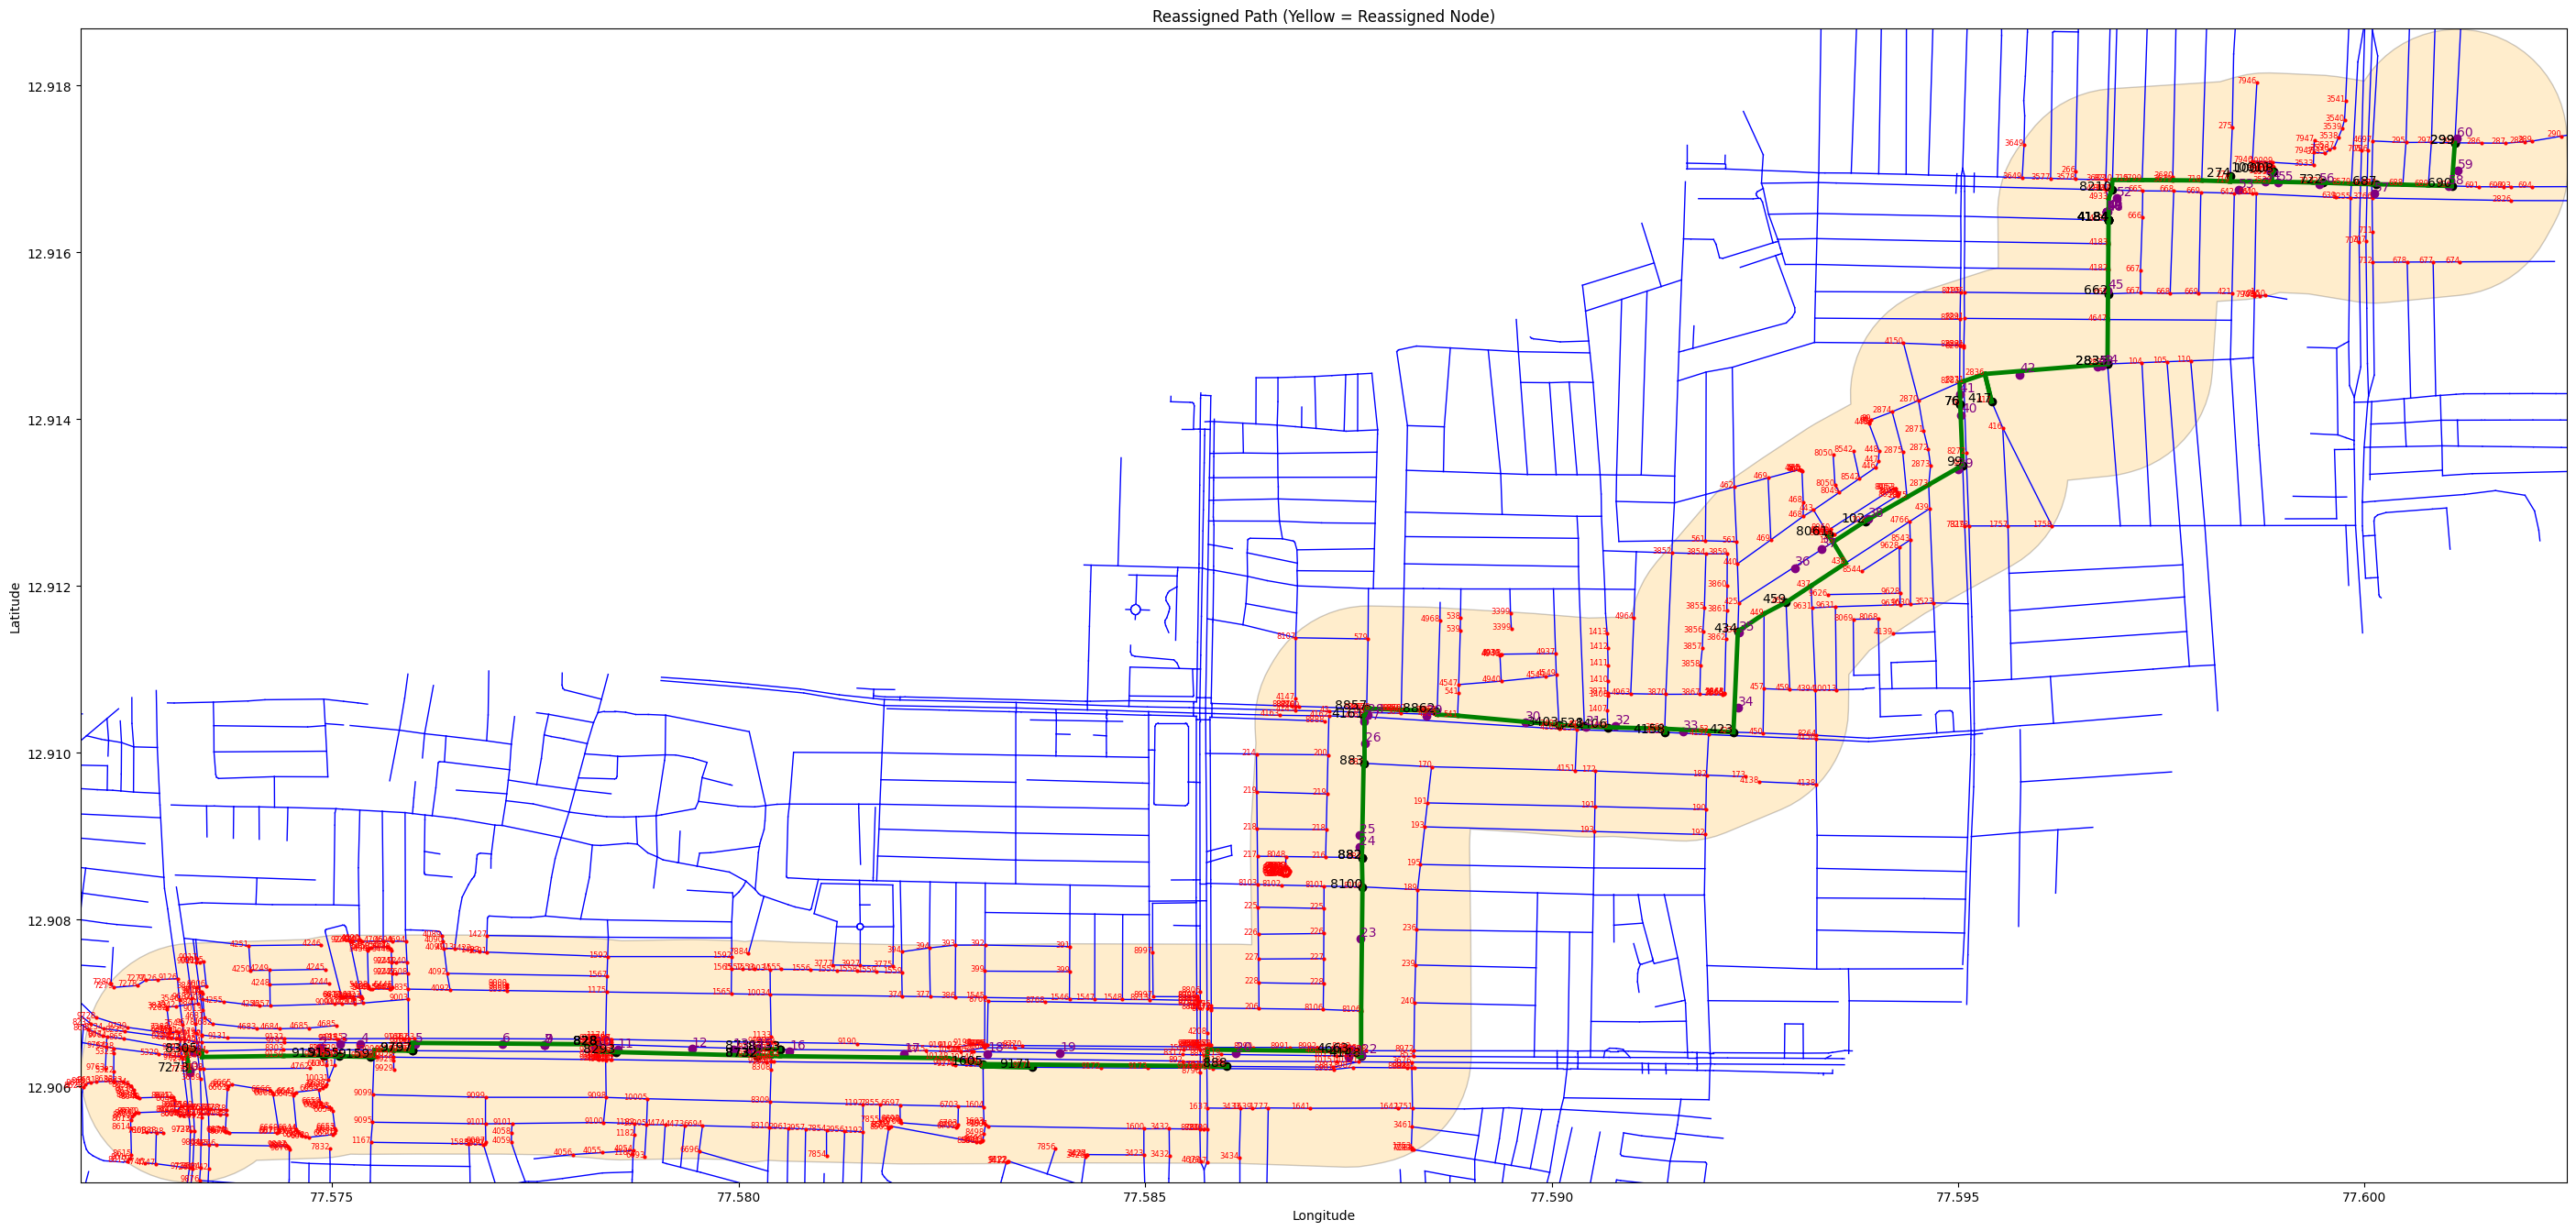

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gpxpy
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from geopy.distance import geodesic
# import math
# import numpy as np

# fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
# gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

# data = gpd.read_file(fp)
# G = nx.Graph()
# coord_to_index = {}

# for idx, line in enumerate(data.geometry):
#     if line.geom_type == 'LineString':
#         start, end = Point(line.coords[0]), Point(line.coords[-1])
#         start_coord = tuple(start.coords[0])
#         end_coord = tuple(end.coords[-1])
#         G.add_node(start_coord, pos=start_coord)
#         G.add_node(end_coord, pos=end_coord)
#         G.add_edge(start_coord, end_coord, geometry=line)
#         coord_to_index[start_coord] = idx
#         coord_to_index[end_coord] = idx

# with open(gpx_file_path, 'r') as gpx_file:
#     gpx = gpxpy.parse(gpx_file)

# start_index = 119
# end_index = 181

# observations = [
#     (point.longitude, point.latitude)
#     for track in gpx.tracks
#     for segment in track.segments
#     for i, point in enumerate(segment.points)
#     if start_index <= i < end_index
# ]

# observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
# gpx_path = LineString(observations_2_no)
# gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
# gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
# geofence_buffered_3857 = gpx_gdf_3857.buffer(150)
# geofence = geofence_buffered_3857.to_crs(epsg=4326)

# connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# if connected_components:
#     subgraph = G.subgraph(connected_components[0]).copy()
#     pos = nx.get_node_attributes(subgraph, 'pos')
#     states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

#     def geodesic_distance(a, b):
#         return geodesic(a, b).kilometers

#     def shortest_path_distance(G, source, target):
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
#         return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

#     def calculate_heading(p1, p2):
#         lat1, lon1 = map(math.radians, p1)
#         lat2, lon2 = map(math.radians, p2)
#         d_lon = lon2 - lon1
#         x = math.sin(d_lon) * math.cos(lat2)
#         y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
#         return (math.degrees(math.atan2(x, y)) + 360) % 360

#     def angle_diff_signed(a, b):
#         diff = (b - a + 360) % 360
#         return diff - 360 if diff > 180 else diff
        
#     def reassign_node(fixed_node, obs_heading, i):
#         candidates = []
#         obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#             _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#             dist_difference = abs(dist_to_candidate - obs_dist)
#             if angle_difference <= 5 and dist_difference <= 0.18:
#                 candidates.append((angle_difference, dist_difference, candidate))
#         candidates.sort(key=lambda x: (x[0], x[1]))
#         for cand in candidates:
#             idx = coord_to_index.get(cand[2], 'N/A')
#             print(f"Candidate idx: {idx}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
#         for angle_diff, dist_diff, candidate in candidates:
#             prev_node = reassigned_nodes[-1]
#             next_node = tuple(matched_coordinates_2[i + 1]) if i + 1 < len(matched_coordinates_2) else None
#             valid = True
#             if nx.has_path(subgraph, prev_node, candidate):
#                 _, d1 = shortest_path_distance(subgraph, prev_node, candidate)
#                 if d1 * 1000 > 250:
#                     valid = False
#             if next_node and candidate in pos and next_node in pos and nx.has_path(subgraph, candidate, next_node):
#                 _, d2 = shortest_path_distance(subgraph, candidate, next_node)
#                 if d2 * 1000 > 250:
#                     valid = False
#             if valid:
#                 return candidate, (angle_diff, dist_diff)
#         return None, None
#     # def reassign_node(fixed_node, obs_heading, i):
#     #     candidates = []
#     #     obs_dist = geodesic(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i]).km
#     #     for candidate in states_in_geofence_2:
#     #         if not nx.has_path(subgraph, fixed_node, candidate):
#     #             continue
#     #         node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#     #         angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#     #         _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#     #         dist_difference = abs(dist_to_candidate - obs_dist)
#     #         if angle_difference <= 5 and dist_difference <= 0.07:  
#     #             candidates.append((angle_difference, dist_difference, candidate))
#     #     for cand in candidates[:5]:
#     #         print(f"Candidate idx: {coord_to_index.get(cand[2], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
#     #     if candidates:
#     #         candidates.sort(key=lambda x: (x[1], x[0]))
#     #         print(f"\nTop 5 candidate node numbers for observation {i}: {[coord_to_index.get(c[2], 'N/A') for c in candidates[:5]]}")
#     #         best_candidate = candidates[0]
#     #         return best_candidate[2], best_candidate  
#     #     return None, None

#     reassigned_nodes = [tuple(matched_coordinates_2[0])]
#     reassigned_log = []
#     reassignment_memory = {}
#     reassignment_flags = set()

#     max_len = min(len(highlighted_distances), len(distances_2_2))
#     for i in range(max_len):
#         path_length = highlighted_distances[i]
#         geo_dist = distances_2_2[i]
#         distance_diff = abs(path_length - geo_dist)
#         if distance_diff > 100:
#             reassignment_flags.add(i)

#     for i in range(1, min(len(matched_coordinates_2), len(observations_2_no_duplicates))):
#         fixed_node = reassigned_nodes[-1]
#         target_node = tuple(matched_coordinates_2[i])
#         original_index = coord_to_index.get(target_node, None)

#         if original_index in reassignment_memory:
#             reassigned = reassignment_memory[original_index]
#             reassigned_nodes.append(reassigned)
#             continue

#         if i in reassignment_flags:
#             obs_heading = calculate_heading(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i])
#             reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
#             if reassigned:
#                 reassigned_nodes.append(reassigned)
#                 idx = coord_to_index.get(reassigned, "N/A")
#                 reassignment_memory[original_index] = reassigned
#                 print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
#                 reassigned_log.append((target_node, reassigned, idx, candidate_info))
#             else:
#                 reassigned_nodes.append(fixed_node)
#                 idx = coord_to_index.get(fixed_node, "N/A")
#                 print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no_duplicates[i]}")
#         else:
#             reassigned_nodes.append(target_node)

#     fig, ax = plt.subplots(figsize=(35, 17))

#     for edge in subgraph.edges(data=True):
#         line = edge[2]['geometry']
#         x, y = line.xy
#         ax.plot(x, y, color='blue', linewidth=1)

#     for node in states_in_geofence:
#         x, y = pos[node]
#         ax.plot(x, y, marker='o', color='red', markersize=2)
#         idx = coord_to_index.get((x, y), None)
#         if idx is not None:
#             ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

#     for node in reassigned_nodes:
#         if node in pos and geofence.geometry[0].contains(Point(pos[node])):
#             x, y = node
#             color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
#             ax.plot(x, y, marker='o', color=color, markersize=6)
#             idx = coord_to_index.get((x, y), None)
#             if idx is not None:
#                 ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

#     for i, pt in enumerate(observations_2_no):
#         obs_point = Point(pt)
#         if geofence.geometry[0].contains(obs_point):
#             ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
#             ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

#     plotted_edges = set()
#     print("--Segment Distances--")
#     for i in range(1, len(reassigned_nodes)):
#         a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
#         if a in pos and b in pos and nx.has_path(subgraph, a, b):
#             path, d = shortest_path_distance(subgraph, a, b)
#             print(f"Segment {i}: {d*1000:.2f} m")
#             for j in range(len(path) - 1):
#                 edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
#                 if (path[j], path[j + 1]) not in plotted_edges:
#                     x, y = edge_geom.xy
#                     ax.plot(x, y, color='green', linewidth=3.5)
#                     plotted_edges.add((path[j], path[j + 1]))

#     geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
#     minx, miny, maxx, maxy = geofence.total_bounds
#     ax.set_xlim(minx - 1e-6, maxx + 1e-6)
#     ax.set_ylim(miny - 1e-6, maxy + 1e-6)
#     plt.title("Reassigned Path (Yellow = Reassigned Node)")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 119
end_index = 181

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
gpx_path = LineString(observations_2_no)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)
geofence = geofence_buffered_3857.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lat1, lon1 = map(math.radians, p1)
        lat2, lon2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.17:
                candidates.append((angle_difference, dist_difference, candidate))
        candidates.sort(key=lambda x: (x[0], x[1]))
        for cand in candidates:
            idx = coord_to_index.get(cand[2], 'N/A')
            print(f"Candidate idx: {idx}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        for angle_diff, dist_diff, candidate in candidates:
            prev_node = reassigned_nodes[-1]
            next_node = tuple(matched_coordinates_2[i + 1]) if i + 1 < len(matched_coordinates_2) else None
            valid = True
            if nx.has_path(subgraph, prev_node, candidate):
                _, d1 = shortest_path_distance(subgraph, prev_node, candidate)
                if d1 * 1000 > 200:
                    valid = False
            if next_node and candidate in pos and next_node in pos and nx.has_path(subgraph, candidate, next_node):
                _, d2 = shortest_path_distance(subgraph, candidate, next_node)
                if d2 * 1000 > 200:
                    valid = False
            if valid:
                return candidate, (angle_diff, dist_diff)
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_2[0])]
    reassigned_log = []
    reassignment_memory = {}
    reassignment_flags = set()

    max_len = min(len(highlighted_distances), len(distances_2_2))
    for i in range(max_len):
        path_length = highlighted_distances[i]
        geo_dist = distances_2_2[i]
        distance_diff = abs(path_length - geo_dist)
        if distance_diff > 100:
            reassignment_flags.add(i)

    to_process = list(range(1, min(len(matched_coordinates_2), len(observations_2_no))))
    forced_flags = set()

    while to_process:
        i = to_process.pop(0)
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_2[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        force_reassign = i in reassignment_flags or i in forced_flags
        if force_reassign:
            obs_heading = calculate_heading(observations_2_no[i - 1], observations_2_no[i])
            reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
            if reassigned:
                reassigned_nodes.append(reassigned)
                idx = coord_to_index.get(reassigned, "N/A")
                reassignment_memory[original_index] = reassigned
                print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
                reassigned_log.append((target_node, reassigned, idx, candidate_info))

                if i + 1 < len(matched_coordinates_2):
                    next_node = tuple(matched_coordinates_2[i + 1])
                    if reassigned in pos and next_node in pos and nx.has_path(subgraph, reassigned, next_node):
                        _, d = shortest_path_distance(subgraph, reassigned, next_node)
                        if d * 1000 > 200:
                            forced_flags.add(i + 1)
                            if i + 1 not in to_process:
                                to_process.insert(0, i + 1)
            else:
                reassigned_nodes.append(fixed_node)
                idx = coord_to_index.get(fixed_node, "N/A")
                print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no[i]}")
        else:
            reassigned_nodes.append(target_node)

    fig, ax = plt.subplots(figsize=(35, 17))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_2_no):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [126]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gpxpy
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from geopy.distance import geodesic
# import math
# import numpy as np

# fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i71_500m.shp"
# gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/fef5d67f-393f-4bc1-9736-ec1a97b0e205_493.gpx'

# data = gpd.read_file(fp)
# G = nx.Graph()
# coord_to_index = {}

# for idx, line in enumerate(data.geometry):
#     if line.geom_type == 'LineString':
#         start, end = Point(line.coords[0]), Point(line.coords[-1])
#         start_coord = tuple(start.coords[0])
#         end_coord = tuple(end.coords[-1])
#         G.add_node(start_coord, pos=start_coord)
#         G.add_node(end_coord, pos=end_coord)
#         G.add_edge(start_coord, end_coord, geometry=line)
#         coord_to_index[start_coord] = idx
#         coord_to_index[end_coord] = idx

# with open(gpx_file_path, 'r') as gpx_file:
#     gpx = gpxpy.parse(gpx_file)

# start_index = 119
# end_index = 181

# observations = [
#     (point.longitude, point.latitude)
#     for track in gpx.tracks
#     for segment in track.segments
#     for i, point in enumerate(segment.points)
#     if start_index <= i < end_index
# ]

# observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
# gpx_path = LineString(observations_2_no)
# gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
# gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
# geofence_buffered_3857 = gpx_gdf_3857.buffer(150)
# geofence = geofence_buffered_3857.to_crs(epsg=4326)

# connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# if connected_components:
#     subgraph = G.subgraph(connected_components[0]).copy()
#     pos = nx.get_node_attributes(subgraph, 'pos')
#     states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

#     def geodesic_distance(a, b):
#         return geodesic(a, b).kilometers

#     def shortest_path_distance(G, source, target):
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
#         return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

#     def calculate_heading(p1, p2):
#         lat1, lon1 = map(math.radians, p1)
#         lat2, lon2 = map(math.radians, p2)
#         d_lon = lon2 - lon1
#         x = math.sin(d_lon) * math.cos(lat2)
#         y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
#         return (math.degrees(math.atan2(x, y)) + 360) % 360

#     def angle_diff_signed(a, b):
#         diff = (b - a + 360) % 360
#         return diff - 360 if diff > 180 else diff

#     def reassign_node(fixed_node, obs_heading, i):
#         candidates = []
#         obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#             _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#             dist_difference = abs(dist_to_candidate - obs_dist)
#             if angle_difference <= 5 and dist_difference <= 0.07:
#                 candidates.append((angle_difference, dist_difference, candidate))
#         if candidates:
#             candidates.sort(key=lambda x: (x[1], x[0]))
#             return candidates[0][2], candidates[0]
#         return None, None

#     def fallback_reassign(fixed_node, i, lookahead=5):
#         lookahead_obs = observations_2_no[i : i + lookahead]
#         if len(lookahead_obs) < 2:
#             return None, None
#         headings = [calculate_heading(lookahead_obs[j], lookahead_obs[j + 1]) for j in range(len(lookahead_obs) - 1)]
#         avg_heading = sum(headings) / len(headings)
#         candidates = []
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(avg_heading, node_heading))
#             _, path_distance = shortest_path_distance(subgraph, fixed_node, candidate)
#             if angle_difference <= 45:
#                 candidates.append((angle_difference, path_distance, candidate))
#         if candidates:
#             candidates.sort(key=lambda x: (x[1], x[0]))
#             return candidates[0][2], candidates[0]
#         return None, None

#     matched_coordinates_2 = list(pos.keys())
#     observations_2_no_duplicates = observations_2_no

#     reassigned_nodes = [tuple(matched_coordinates_2[0])]
#     reassigned_log = []
#     reassignment_memory = {}

#     for i in range(1, min(len(matched_coordinates_2), len(observations_2_no_duplicates))):
#         fixed_node = reassigned_nodes[-1]
#         target_node = tuple(matched_coordinates_2[i])
#         original_index = coord_to_index.get(target_node, None)
#         if original_index in reassignment_memory:
#             reassigned = reassignment_memory[original_index]
#             reassigned_nodes.append(reassigned)
#             continue
#         if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
#             _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
#             if dist <= 0.1:
#                 reassigned_nodes.append(target_node)
#                 continue
#         obs_heading = calculate_heading(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i])
#         reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
#         if not reassigned:
#             reassigned, candidate_info = fallback_reassign(fixed_node, i)
#         if reassigned:
#             reassigned_nodes.append(reassigned)
#             idx = coord_to_index.get(reassigned, "N/A")
#             reassignment_memory[original_index] = reassigned
#             print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
#             reassigned_log.append((target_node, reassigned, idx, candidate_info))
#         else:
#             reassigned_nodes.append(fixed_node)
#             idx = coord_to_index.get(fixed_node, "N/A")
#             print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no_duplicates[i]}")

#     fig, ax = plt.subplots(figsize=(35, 17))

#     for edge in subgraph.edges(data=True):
#         line = edge[2]['geometry']
#         x, y = line.xy
#         ax.plot(x, y, color='blue', linewidth=1)

#     for node in states_in_geofence:
#         x, y = pos[node]
#         ax.plot(x, y, marker='o', color='red', markersize=2)
#         idx = coord_to_index.get((x, y), None)
#         if idx is not None:
#             ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

#     for node in reassigned_nodes:
#         if node in pos and geofence.geometry[0].contains(Point(pos[node])):
#             x, y = node
#             color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
#             ax.plot(x, y, marker='o', color=color, markersize=6)
#             idx = coord_to_index.get((x, y), None)
#             if idx is not None:
#                 ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

#     for i, pt in enumerate(observations_2_no):
#         obs_point = Point(pt)
#         if geofence.geometry[0].contains(obs_point):
#             ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
#             ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

#     plotted_edges = set()
#     print("--Segment Distances--")
#     for i in range(1, len(reassigned_nodes)):
#         a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
#         if a in pos and b in pos and nx.has_path(subgraph, a, b):
#             path, d = shortest_path_distance(subgraph, a, b)
#             print(f"Segment {i}: {d*1000:.2f} m")
#             for j in range(len(path) - 1):
#                 edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
#                 if (path[j], path[j + 1]) not in plotted_edges:
#                     x, y = edge_geom.xy
#                     ax.plot(x, y, color='green', linewidth=3.5)
#                     plotted_edges.add((path[j], path[j + 1]))

#     geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
#     minx, miny, maxx, maxy = geofence.total_bounds
#     ax.set_xlim(minx - 1e-6, maxx + 1e-6)
#     ax.set_ylim(miny - 1e-6, maxy + 1e-6)
#     plt.title("Reassigned Path (Yellow = Reassigned Node)")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()


In [131]:
index1 = 8999
index2 = 8293
index_to_coord = {v: k for k, v in coord_to_index.items()}
node1 = index_to_coord.get(index1)
node2 = index_to_coord.get(index2)

if node1 is None or node2 is None:
    print("Invalid index.")
elif nx.has_path(subgraph, node1, node2):
    print("Path exists between the nodes.")
    path = nx.shortest_path(
        subgraph,
        source=node1,
        target=node2,
        weight=lambda u, v, d: geodesic_distance(pos[u], pos[v])
    )

    total_length = 0
    for u, v in zip(path[:-1], path[1:]):
        total_length += geodesic_distance(pos[u], pos[v])

    heading_angle = calculate_heading(node1, node2)
    
    print("Shortest path length (meters):", total_length)
    print("Number of edges in path:", len(path) - 1)
    print(f"Heading angle from node {index1} to {index2}: {heading_angle:.2f}°")

Path exists between the nodes.
Shortest path length (meters): 0.16766052917958968
Number of edges in path: 9
Heading angle from node 8999 to 8293: 353.23°


In [78]:
index1 = 18
index2 = 19

if index1 < 0 or index2 < 0 or index1 >= len(observations_2_no_duplicates) or index2 >= len(observations_2_no_duplicates):
    print("Invalid observation index.")
else:
    pt1 = observations_2_no_duplicates[index1]
    pt2 = observations_2_no_duplicates[index2]

    heading_angle = calculate_heading(pt1, pt2)
    geodist = geodesic(pt1[::-1], pt2[::-1]).meters

    print(f"Geodesic Distance: {geodist:.2f} meters")
    print(f"Heading Angle: {heading_angle:.2f}°")


Geodesic Distance: 96.65 meters
Heading Angle: 0.14°


In [133]:
from tabulate import tabulate
mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_2_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))


Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5732539, 12.9061655)  (77.5732437, 12.9061862)               7273
          1  (77.5732982, 12.9064079)  (77.5733416, 12.9064214)               8305
          2  (77.574845, 12.9064589)   (77.5748932, 12.9063671)               9151
          3  (77.5751004, 12.906508)   (77.5750864, 12.9063613)               9155
          4  (77.5753445, 12.906504)   (77.5754652, 12.9063536)               9159
          5  (77.5760242, 12.9065071)  (77.5759867, 12.9064275)               9797
          6  (77.5770948, 12.9065062)  (77.5759867, 12.9064275)               9797
          7  (77.5776073, 12.906499)   (77.5782584, 12.9065044)                828
          8  (77.5776153, 12.9065007)  (77.5782584, 12.9065044)                828
          9  (77.5776153, 12.9065004)  (

In [134]:
from tabulate import tabulate
print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_2_no_duplicates)):
    obs1 = observations_2_no_duplicates[i - 1]
    obs2 = observations_2_no_duplicates[i]
    geod = geodesic(obs1, obs2).meters 

    matched1 = tuple(matched_coordinates_2[i - 1])
    matched2 = tuple(matched_coordinates_2[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            8305 │               8305 │         7.6416 │            24.3918 │               24.3918 │                    16.7502 │                       16.7502 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            9151 │               9151 │      